# Global Fishing Effort Suspected Fishing Vessels

In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib import colors,colorbar
import matplotlib
%matplotlib inline
import csv 
import math
# from scipy import stats

In [3]:
import bq  
client = bq.Client.Get()

In [4]:
def Query(q):
    t0 = time.time()
    answer = client.ReadTableRows(client.Query(q)['configuration']['query']['destinationTable'])
    print 'Query time: ' + str(time.time() - t0) + ' seconds.'
    return answer


In [6]:
# how many vessels?
q = ''' SELECT count(*) FROM
      [scratch_global_fishing_raster.classification_results_20160506]
    WHERE max_label_label = "Purse seine" 
    and mmsi not in(select string(mmsi) from [scratch_bjorn.2015_combined_fishing])'''
suspected_purse_seiene = int(Query(q)[0][0])

# how many vessels?
q = ''' SELECT count(*) FROM
      [scratch_global_fishing_raster.classification_results_20160506]
    WHERE max_label_label = "Longliner" 
    and mmsi not in(select string(mmsi) from [scratch_bjorn.2015_combined_fishing])'''
suspected_longliner = int(Query(q)[0][0])

# how many vessels?
q = ''' SELECT count(*) FROM
      [scratch_global_fishing_raster.classification_results_20160506]
    WHERE max_label_label = "Trawler" 
    and mmsi not in(select string(mmsi) from [scratch_bjorn.2015_combined_fishing])'''
suspected_trawler = int(Query(q)[0][0])

# how many vessels?
q = ''' SELECT count(*) FROM
      [scratch_global_fishing_raster.classification_results_20160506]
    WHERE max_label_label = "Pots and traps" 
    and mmsi not in(select string(mmsi) from [scratch_bjorn.2015_combined_fishing])'''
suspected_pots = int(Query(q)[0][0])



Waiting on bqjob_r39d8252fce53eca0_00000154a7753bc0_1 ... (0s) Current status: DONE   
Query time: 2.7574660778 seconds.
Waiting on bqjob_r6edd13e6de4a56cc_00000154a7754686_2 ... (0s) Current status: DONE   
Query time: 1.58404707909 seconds.
Waiting on bqjob_r3d525a010389291f_00000154a7754cb7_3 ... (0s) Current status: DONE   
Query time: 2.45967006683 seconds.
Waiting on bqjob_r66260937d5a08205_00000154a7755653_4 ... (0s) Current status: DONE   
Query time: 2.45385098457 seconds.


In [7]:
print suspected_purse_seiene, "Suspected Purse Seiners"
print suspected_longliner, "Suspected Longliners"
print suspected_trawler, "Suspected Trawlers"
print suspected_pots, "Suspected Pots and Traps"

6281 Suspected Purse Seiners
2467 Suspected Longliners
4269 Suspected Trawlers
622 Suspected Pots and Traps


In [13]:
def makeMap(vessel_type):
    q = '''
    SELECT
      INTEGER(lat*2) lat_bin,
      INTEGER(lon*2) lon_bin,
      SUM(fishing_hours) fishing_hours
    FROM (
      SELECT
        lat,
        lon,
        (last_hours + next_hours)/2 fishing_hours
      FROM
        [scratch_global_fishing_raster.2015_with_score_and_hours]
      WHERE
        measure_new_score > .5
        AND lat <90
        AND lon <180
        AND mmsi IN (
        SELECT
          INTEGER(mmsi)
        FROM
          [scratch_global_fishing_raster.classification_results_20160506]
        WHERE
          max_label_label = "'''+vessel_type+'''" 
           and mmsi not in (select string(mmsi)
              from [scratch_bjorn.2015_combined_fishing]))
        AND seg_id IN (
        SELECT
          seg_id,
        FROM
          [scratch_david_seg_analysis.2015_segments]
        WHERE
          NOT( point_count<=20
            OR (point_count<100
              AND point_count = terrestrial_positions)
            OR (min_lat >= 0
              AND max_lat <= 0.109225)
            OR (min_lon >= 0
              AND max_lon <= 0.109225) )))
    GROUP BY
      lat_bin,
      lon_bin
    '''


    fishing_grid = Query(q)
    
    cellsize = .5
    one_over_cellsize = 2
    max_lat = 90
    min_lat = -90
    min_lon = -180
    max_lon = 180

    num_lats = (max_lat-min_lat)*one_over_cellsize
    num_lons = (max_lon-min_lon)*one_over_cellsize

    grid = np.zeros(shape=(num_lats,num_lons))

    for row in fishing_grid:
        lat = int(row[0])
        lon = int(row[1])
        lat_index = lat-min_lat*one_over_cellsize
        lon_index = lon-min_lon*one_over_cellsize
        grid[lat_index][lon_index] = float(row[2])
        

        
    plt.rcParams["figure.figsize"] = [12,7]

    cutoff = 0 # 4 degress away from the pole
    firstlat = 90-cutoff
    lastlat = -90+cutoff
    firstlon = -180
    lastlon = 180
    scale = cellsize
    one_over_cellsize = 2

    fishing_days_truncated = grid[one_over_cellsize*cutoff:(180*one_over_cellsize)-cutoff*one_over_cellsize][:]

    numlats = int((firstlat-lastlat)*one_over_cellsize+.5)
    numlons = int((lastlon-firstlon)*one_over_cellsize+.5)

    lat_boxes = np.linspace(lastlat,firstlat,num=numlats,endpoint=False)
    lon_boxes = np.linspace(firstlon,lastlon,num=numlons,endpoint=False)

    fig = plt.figure()
    m = Basemap(llcrnrlat=lastlat, urcrnrlat=firstlat,
              llcrnrlon=lastlon, urcrnrlon=firstlon, lat_ts=0, projection='robin',resolution="h", lon_0=0)

    m.drawmapboundary(fill_color='#111111')
    # m.drawcoastlines(linewidth=.2)
    m.fillcontinents('#111111',lake_color='#111111')#, lake_color, ax, zorder, alpha)

    x = np.linspace(-180, 180, 360*one_over_cellsize)
    y = np.linspace(lastlat, firstlat, (firstlat-lastlat)*one_over_cellsize)
    x, y = np.meshgrid(x, y)
    converted_x, converted_y = m(x, y)
    from matplotlib import colors,colorbar

    maximum = grid.max()
    minimum = 1

    norm = colors.LogNorm(vmin=minimum, vmax=maximum)
    # norm = colors.Normalize(vmin=0, vmax=1000)

    m.pcolormesh(converted_x, converted_y, fishing_days_truncated, norm=norm, vmin=minimum, vmax=maximum, cmap = plt.get_cmap('viridis'))

    t = "Fishing Hours for Suspected "+ vessel_type+" in 2015"
    plt.title(t, color = "#ffffff", fontsize=18)

    ax = fig.add_axes([0.2, 0.1, 0.4, 0.02]) #x coordinate , 
    norm = colors.LogNorm(vmin=minimum, vmax=maximum)
    # norm = colors.Normalize(vmin=0, vmax=1000)
    lvls = np.logspace(np.log10(minimum),np.log10(maximum),num=8)
    cb = colorbar.ColorbarBase(ax,norm = norm, orientation='horizontal', ticks=lvls, cmap = plt.get_cmap('viridis'))

    the_labels = []
    for l in lvls:
        if l>=1:
            l = int(l)
        the_labels.append(l)

    #cb.ax.set_xticklabels(["0" ,round(m3**.5,1), m3, round(m3**1.5,1), m3*m3,round(m3**2.5,1), str(round(m3**3,1))+"+"], fontsize=10)
    cb.ax.set_xticklabels(the_labels, fontsize=10, color = "#ffffff")
    cb.set_label('Fishing Hours by Two Degree Grid',labelpad=-40, y=0.45, color = "#ffffff")

    ax.text(1.7, -0.5, 'Data Source: Orbcomm\nMap by Global Fishing Watch',
            verticalalignment='bottom', horizontalalignment='right',
            transform=ax.transAxes,
            color='#ffffff', fontsize=6)

    plt.savefig("fishing_hours_suspected_"+vessel_type+".png",bbox_inches='tight',dpi=300,transparent=True,pad_inches=.1, facecolor="#000000")
    plt.show()

Waiting on bqjob_r67738a3828068e72_00000154a779cae1_5 ... (86s) Current status: DONE   
Query time: 89.3673238754 seconds.


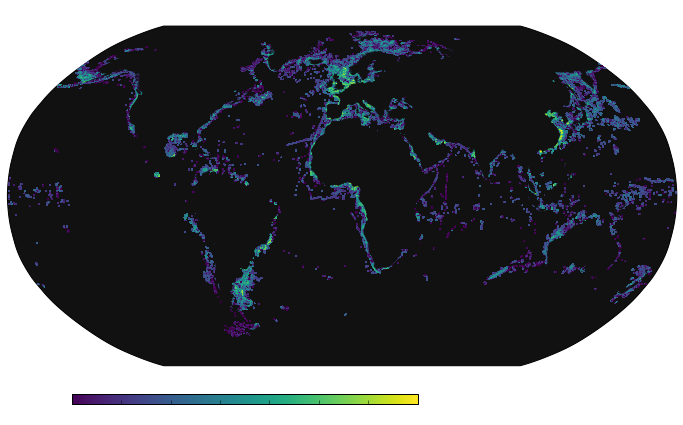

In [9]:
makeMap("Trawler")

Waiting on bqjob_r2b012b674ff8e8ce_00000154a784e059_7 ... (15s) Current status: DONE   
Query time: 18.711315155 seconds.


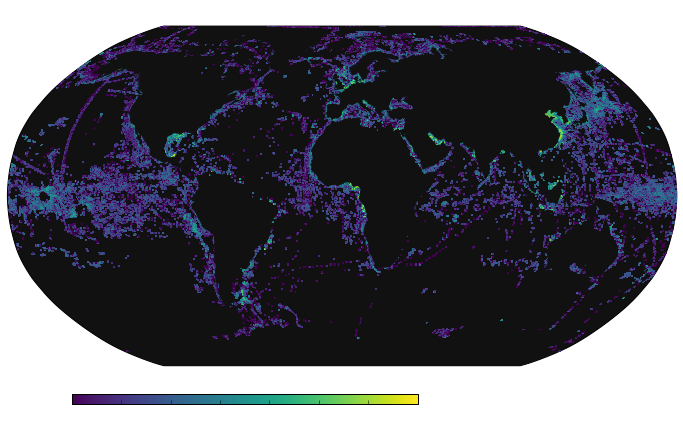

In [14]:
makeMap("Purse seine")

Waiting on bqjob_r6e0f8da11adba4ac_00000154a7861013_8 ... (15s) Current status: DONE   
Query time: 19.8104631901 seconds.


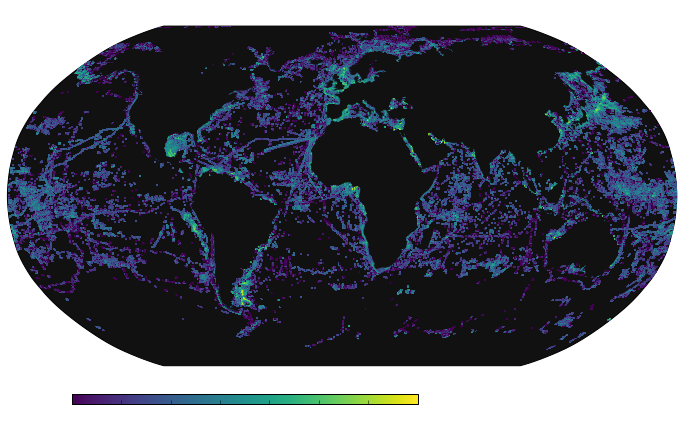

In [15]:
makeMap("Longliner")

Waiting on bqjob_r71d382a0fee8a1c4_00000154a7874073_9 ... (23s) Current status: DONE   
Query time: 25.7040629387 seconds.


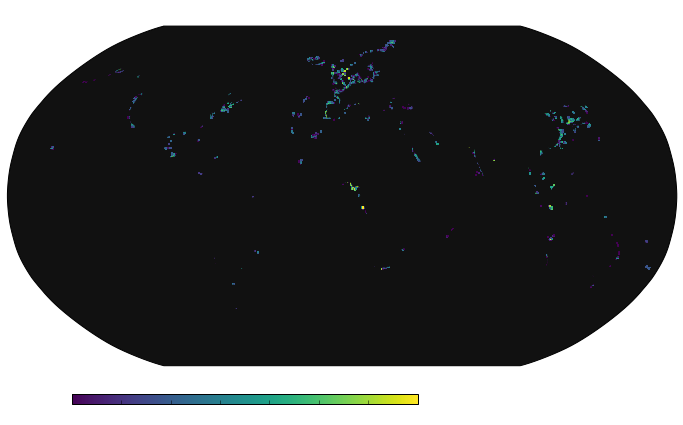

In [16]:
makeMap("Pots and traps")